#### 样本极不均衡

解决方法：   

        1、随机欠采样
        2、过采样
        3、聚类过采样
        4、smote算法

### 2、过采样

In [1]:
import pandas as pd
import os
import math      
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
import time
import warnings 
import seaborn as sns 
warnings.filterwarnings('ignore') 

In [4]:
B_data=pd.read_csv("../../dataSet/GT3X-V2.8-00/Bdata.csv",  index_col="Unnamed: 0")
T_data=pd.read_csv("../../dataSet/GT3X-V2.8-00/Tdata.csv",  index_col="Unnamed: 0")

In [4]:
B_data.head()

,Component ID,Volume(%),Height(um),Area(%),OffsetX(mm),OffsetY(mm),Result,Panel
0,1:C2,98.832,106.662,92.660,0.005,0.000,1,1.0
1,1:C2,95.402,100.189,95.222,0.000,0.000,1,1.0
2,1:C10,103.047,111.748,92.214,-0.011,0.007,1,1.0
3,1:C10,105.500,117.418,89.850,0.000,0.007,1,1.0
4,1:C11,103.741,117.714,88.129,-0.008,-0.006,1,1.0


In [5]:
B_data[B_data['Result']==1]["Volume(%)"]

0           98.832
1           95.402
2          103.047
3          105.500
4          103.741
            ...   
6559428    113.166
6559429    131.565
6559430    124.038
6559431     92.592
6559432    108.823
Name: Volume(%), Length: 6556479, dtype: float64

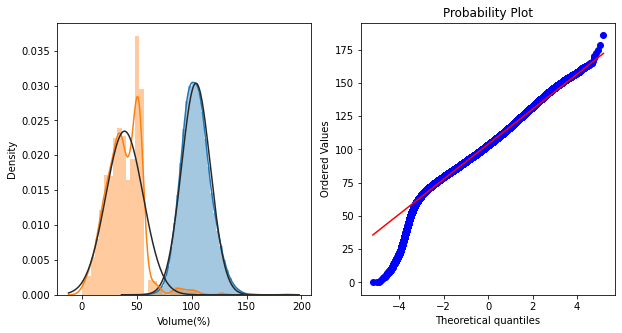

In [5]:
from scipy import stats
fig=plt.figure(figsize=(10,5))
ax=plt.subplot(1,2,1)
sns.distplot(B_data[B_data['Result']==1]["Volume(%)"],fit=stats.norm)
sns.distplot(B_data[B_data['Result']!=1]["Volume(%)"],fit=stats.norm)
ax=plt.subplot(1,2,2)
res=stats.probplot(B_data["Volume(%)"],plot=plt)

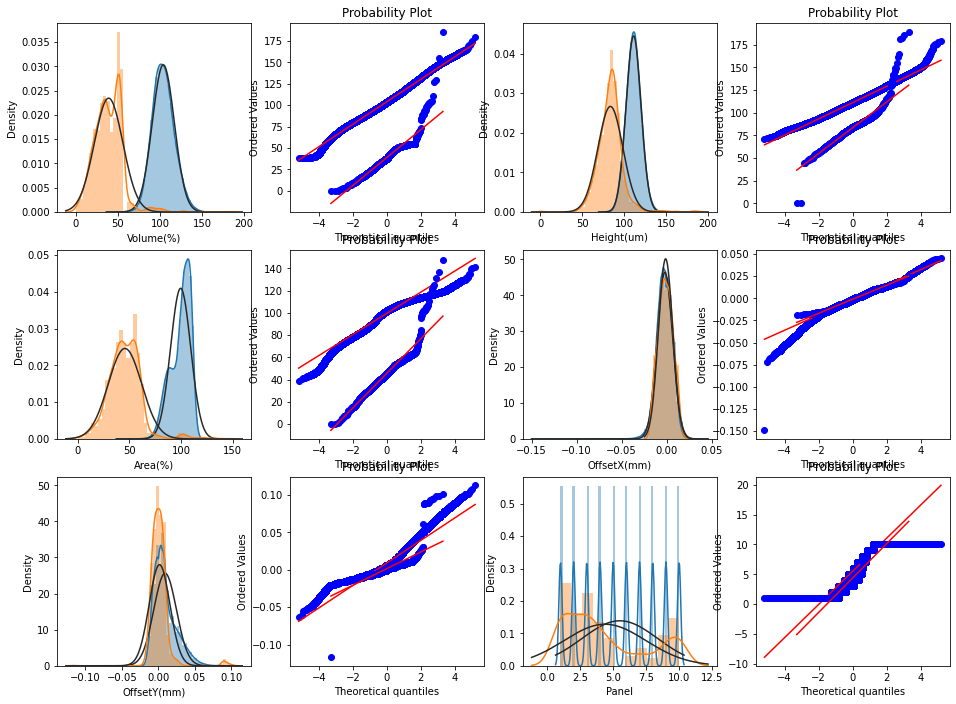

In [36]:
cols=["Volume(%)","Height(um)","Area(%)" , "OffsetX(mm)" ,"OffsetY(mm)" ,"Panel"]
i=0
plt.figure(figsize=(16,16))
for col in  cols:
    i+=1
    ax=plt.subplot(4,4,i)
    sns.distplot(B_data[B_data['Result']==1][col],fit=stats.norm)
    sns.distplot(B_data[B_data['Result']!=1][col],fit=stats.norm)
    i+=1
    ax=plt.subplot(4,4,i)
    res=stats.probplot(B_data[B_data['Result']==1][col],plot=plt)
    res=stats.probplot(B_data[B_data['Result']!=1][col],plot=plt)
plt.show()

偏移量和高度

## 样本不均衡下处理

解决样本极不均衡常规性建模  
异常检验，使用模型对异常值进行检验    
解决方法：

    1、随机欠采样
    2、过采样
    3、聚类过采样
    4、smote算法

#### 异常检验

In [5]:
B_data.shape

(6557880, 8)

In [6]:
B_data.drop_duplicates()

,Component ID,Volume(%),Height(um),Area(%),OffsetX(mm),OffsetY(mm),Result,Panel
0,1:C2,98.832,106.662,92.660,0.005,0.000,1,1.0
1,1:C2,95.402,100.189,95.222,0.000,0.000,1,1.0
2,1:C10,103.047,111.748,92.214,-0.011,0.007,1,1.0
3,1:C10,105.500,117.418,89.850,0.000,0.007,1,1.0
4,1:C11,103.741,117.714,88.129,-0.008,-0.006,1,1.0
...,...,...,...,...,...,...,...,...
6559428,1:VT3,113.166,110.799,102.136,-0.005,0.016,1,10.0
6559429,1:VT3,131.565,120.853,108.864,0.011,0.002,1,10.0
6559430,1:VT4,124.038,124.045,99.994,-0.015,0.008,1,10.0
6559431,1:VT4,92.592,88.401,104.741,-0.003,0.008,1,10.0


**获取异常值**

<AxesSubplot:xlabel='Volume(%)', ylabel='Result'>

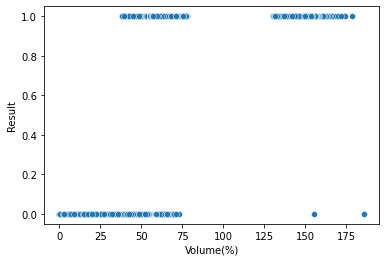

In [7]:
# 计算判断异常点和极端异常点的临界值
outlier_ll = B_data["Volume(%)"].mean() - 2* B_data["Volume(%)"].std()
outlier_ul = B_data["Volume(%)"].mean() + 2* B_data["Volume(%)"].std()

extreme_outlier_ll = B_data["Volume(%)"].mean() - 3* B_data["Volume(%)"].std()
extreme_outlier_ul =B_data["Volume(%)"].mean()+ 3* B_data["Volume(%)"].std()

# 寻找异常点
sns.scatterplot(x="Volume(%)",y="Result",data=B_data.loc[(B_data["Volume(%)"] > outlier_ul) | (B_data["Volume(%)"] < outlier_ll), ["Volume(%)","Result"]])

<AxesSubplot:xlabel='Volume(%)', ylabel='Result'>

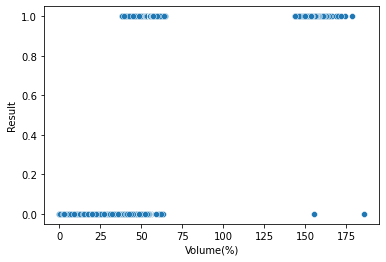

In [8]:
# 寻找极端异常点
sns.scatterplot(x="Volume(%)",y="Result",data=B_data.loc[(B_data["Volume(%)"] > extreme_outlier_ul) | (B_data["Volume(%)"] < extreme_outlier_ll), ["Volume(%)","Result"]])

In [9]:
# 异常值Volume最小值
B_data.loc[(B_data["Volume(%)"] > outlier_ul) | (B_data["Volume(%)"] < outlier_ll), ["Volume(%)","Result"]].groupby("Result").agg(["max","min"])

Volume(%)        
             max     min
Result                  
0        185.814   0.000
1        178.882  38.021

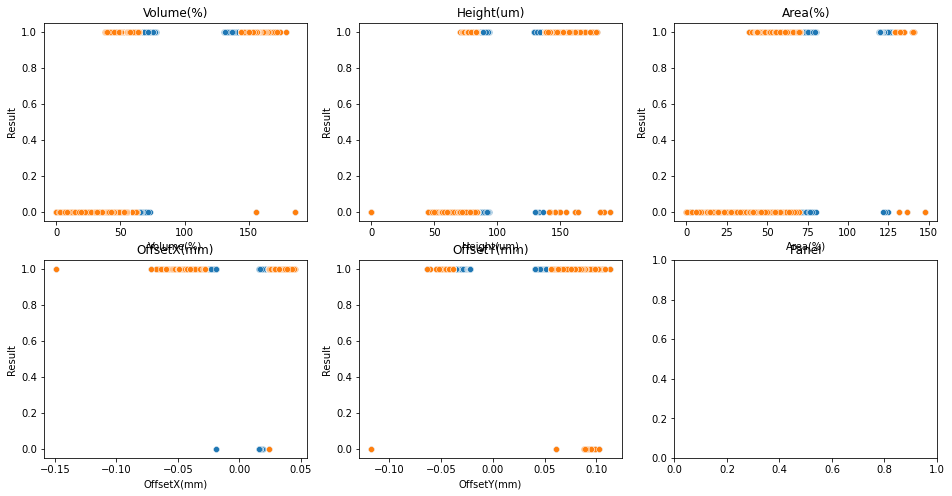

In [12]:
cols=["Volume(%)","Height(um)","Area(%)" , "OffsetX(mm)" ,"OffsetY(mm)" ,"Panel"]
j=0
plt.figure(figsize=(16,12))
for i in cols:
    # 计算判断异常点和极端异常点的临界值
    outlier_ll = B_data[i].mean() - 2* B_data[i].std()
    outlier_ul = B_data[i].mean() + 2* B_data[i].std()

    extreme_outlier_ll = B_data[i].mean() - 3* B_data[i].std()
    extreme_outlier_ul =B_data[i].mean()+ 3* B_data[i].std()
    j+=1
    # 寻找异常点
    plt.subplot(2,3,j)
    sns.scatterplot(x=i,y="Result",data=B_data.loc[(B_data[i] > outlier_ul) | (B_data[i] < outlier_ll), [i,"Result"]])
    sns.scatterplot(x=i,y="Result",data=B_data.loc[(B_data[i] > extreme_outlier_ul) | (B_data[i] < extreme_outlier_ll), [i,"Result"]])
    plt.title(i)
plt.show()

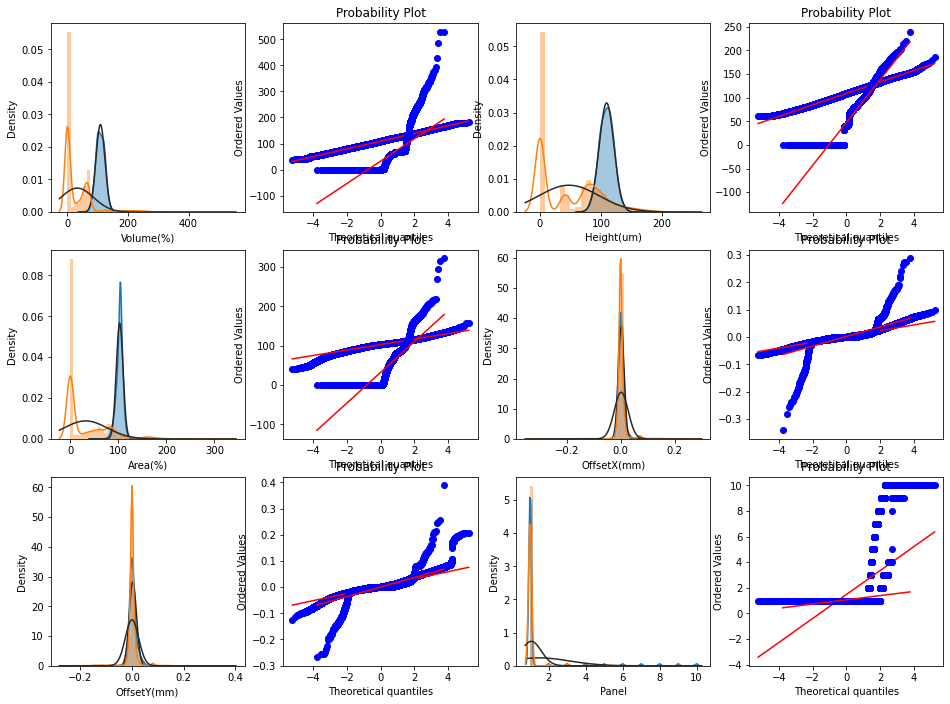

In [20]:
from scipy import stats
cols=["Volume(%)","Height(um)","Area(%)" , "OffsetX(mm)" ,"OffsetY(mm)" ,"Panel"]
i=0
plt.figure(figsize=(16,16))
for col in  cols:
    i+=1
    ax=plt.subplot(4,4,i)
    sns.distplot(T_data[T_data['Result']==1][col],fit=stats.norm)
    sns.distplot(T_data[T_data['Result']!=1][col],fit=stats.norm)
    i+=1
    ax=plt.subplot(4,4,i)
    res=stats.probplot(T_data[T_data['Result']==1][col],plot=plt)
    res=stats.probplot(T_data[T_data['Result']!=1][col],plot=plt)
plt.show()

### 聚类分析

In [5]:
#k-means聚类
from sklearn.cluster import KMeans 
from sklearn import metrics

In [25]:
data=B_data[["Volume(%)","Height(um)","Area(%)"]]
kmeans = KMeans(n_clusters=2, random_state=2021).fit(data)
kmeans.labels_

array([0, 0, 0, ..., 1, 0, 1])

In [31]:
data["labels_"]=kmeans.labels_

In [34]:
data["result"]=B_data["Result"]

In [8]:
data=B_data[["Volume(%)","Height(um)","Area(%)"]]
B_data.head()

,Component ID,Volume(%),Height(um),Area(%),OffsetX(mm),OffsetY(mm),Result,Panel
0,1:C2,98.832,106.662,92.660,0.005,0.000,1,1.0
1,1:C2,95.402,100.189,95.222,0.000,0.000,1,1.0
2,1:C10,103.047,111.748,92.214,-0.011,0.007,1,1.0
3,1:C10,105.500,117.418,89.850,0.000,0.007,1,1.0
4,1:C11,103.741,117.714,88.129,-0.008,-0.006,1,1.0


In [17]:
round(B_data["Volume(%)"]/B_data["Area(%)"],5)*100-B_data["Height(um)"]

0         -1.000000e-03
1          0.000000e+00
2          0.000000e+00
3          0.000000e+00
4          1.000000e-03
               ...     
6559428    0.000000e+00
6559429    1.421085e-14
6559430    0.000000e+00
6559431    0.000000e+00
6559432    1.000000e-03
Length: 6557880, dtype: float64

In [1]:
98.832/92.660

1.0666091085689617

In [2]:
95.402/95.222

1.0018903194639894

In [43]:
data.shape

(6557880, 5)

In [27]:
from mpl_toolkits.mplot3d import Axes3D

In [42]:
data[data["result"]==1]["Volume(%)"]

0           98.832
1           95.402
2          103.047
3          105.500
4          103.741
            ...   
6559428    113.166
6559429    131.565
6559430    124.038
6559431     92.592
6559432    108.823
Name: Volume(%), Length: 6556479, dtype: float64

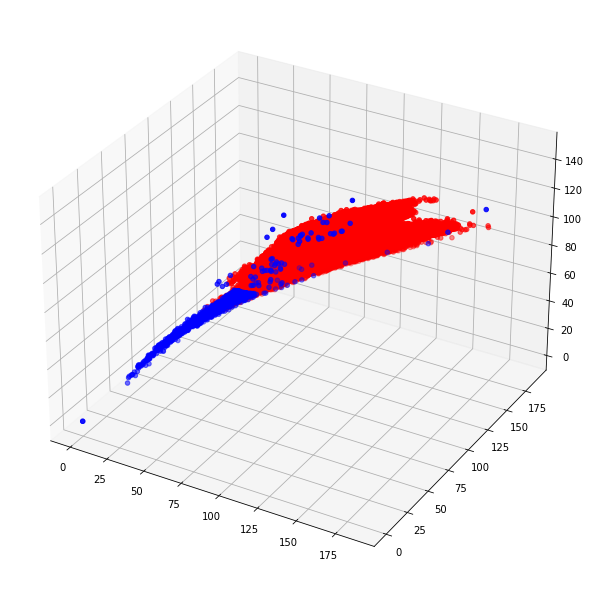

In [45]:
fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)
ax.scatter(data[data["result"]==1]["Volume(%)"]
           ,data[data["result"]==1]["Height(um)"]
           ,data[data["result"]==1]["Area(%)"]
           ,color="r")
ax.scatter(data[data["result"]==0]["Volume(%)"]
           ,data[data["result"]==0]["Height(um)"]
           ,data[data["result"]==0]["Area(%)"]
           ,color="b")
plt.show()

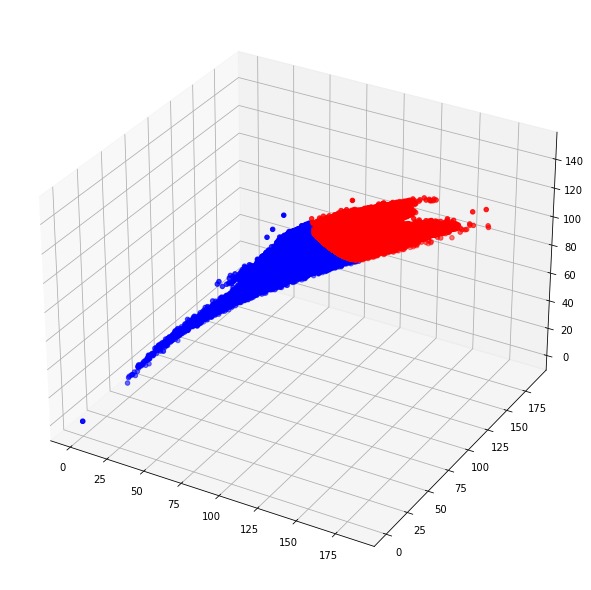

In [47]:
fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)
ax.scatter(data[data["labels_"]==1]["Volume(%)"]
           ,data[data["labels_"]==1]["Height(um)"]
           ,data[data["labels_"]==1]["Area(%)"]
           ,color="r")
ax.scatter(data[data["labels_"]==0]["Volume(%)"]
           ,data[data["labels_"]==0]["Height(um)"]
           ,data[data["labels_"]==0]["Area(%)"]
           ,color="b")
plt.show()

In [26]:
T_data["Result"].value_counts()

1    8288834
0       8606
Name: Result, dtype: int64

In [1]:
# k-means++



#### 肘部法（手肘法）

In [48]:
# 衡量簇内差异来衡量聚类的效果
# 簇内平方和：Total_Inertia
# 应用肘部法则确定 kmeans方法中的k
from scipy.spatial.distance import cdist # 计算两个输入集合的每对之间的距离。
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['Simhei'] #显示中文
plt.rcParams['axes.unicode_minus']=False #显示负号

In [50]:
B_data[["Volume(%)","Height(um)","Area(%)"]]

,Volume(%),Height(um),Area(%)
0,98.832,106.662,92.660
1,95.402,100.189,95.222
2,103.047,111.748,92.214
3,105.500,117.418,89.850
4,103.741,117.714,88.129
...,...,...,...
6559428,113.166,110.799,102.136
6559429,131.565,120.853,108.864
6559430,124.038,124.045,99.994
6559431,92.592,88.401,104.741


In [51]:
# 簇内平方和：Total_Inertia
# 应用肘部法则确定 kmeans方法中的k
from scipy.spatial.distance import cdist # 计算两个输入集合的每对之间的距离。
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['Simhei'] #显示中文
plt.rcParams['axes.unicode_minus']=False #显示负号
X=B_data[["Volume(%)","Height(um)","Area(%)"]]
K=range(1,10)
# 直接计算sse
sse_result=[]
for k in K:
    kmeans=KMeans(n_clusters=k, random_state=2021)
    kmeans.fit(X)
    sse_result.append(sum(np.min(cdist(X,kmeans.cluster_centers_,'euclidean'),axis=1))/X.shape[0])
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(K,sse_result,'gp-')
plt.xlabel('k',fontsize=20)
plt.ylabel(u'平均畸变程度')
plt.title(u'肘部法则确定最佳的K值(1)',fontdict={'fontsize':15})

# 第二种，使用inertia_
L = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=2021)
    kmeans.fit(X)
    L.append((k, kmeans.inertia_))
a = pd.DataFrame(L)
a.columns = ['k', 'inertia']
plt.subplot(1,2,2)
plt.plot(a.k, a.inertia,'gp-')
plt.xlabel('k',fontsize=20)
plt.ylabel('inertia')
plt.title(u'肘部法则确定最佳的K值(2)',fontdict={'fontsize':15})
plt.xticks(a.k)
plt.show();

MemoryError: Unable to allocate 150. MiB for an array with shape (3, 6557880) and data type float64

#### DBSCAN聚类


#### 层次聚类